In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import tensorflow_addons as tfa
import seaborn as sns
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical

In [2]:
train_dir = "../input/cats-and-dogs-image-classification/train"
train_class=os.listdir(train_dir)
print(train_class)



test_dir = "../input/cats-and-dogs-image-classification/test"
test_class=os.listdir(test_dir)
print(test_class)

['dogs', 'cats']
['dogs', 'cats']


In [3]:
x=[] 
y=[]

for folder in os.listdir(train_dir):
    image_list=os.listdir(train_dir+"/"+folder)
    for img_name in image_list:
        
        img=image.load_img(train_dir+"/"+folder+"/"+img_name,target_size=(224,224))
        img=image.img_to_array(img)
      
        
        x.append(img) 
        y.append(train_class.index(folder)) 
        
print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [4]:
test_img=[]
test_labels=[]
for folder in os.listdir(test_dir):
    img_list=os.listdir(test_dir+"/"+folder)
    for images in img_list:
        img =image.load_img(test_dir+"/"+folder+"/"+images,target_size=(224,224))
        img = image.img_to_array(img)
        test_img.append(img)
        test_labels.append(test_class.index(folder))
        
print ('prep completed')

prep completed


In [5]:
# converting the array into a numy arrays 
# Training Dataset
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

print("Test Dataset")

test_img=np.array(test_img) 
print(test_img.shape)

test_labels=to_categorical(test_labels) # onehot encoding of the labels)
print(test_labels.shape)

Training Dataset
(557, 224, 224, 3)
(557, 2)
Test Dataset
(140, 224, 224, 3)
(140, 2)


In [7]:
#data augmentation 
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x)

augmented_images = []
augmented_labels = []

for X_batch, y_batch in datagen.flow(x, y, batch_size=16):
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)
    
    if len(augmented_images) >= 1000:  # Stop after generating 1000 augmented images
        break



In [15]:
X_train = np.concatenate((x, np.concatenate(augmented_images)))
y_train = np.concatenate((y, np.concatenate(augmented_labels)))

In [19]:
X_train.shape

#y_train.shape

(2151, 224, 224, 3)

In [26]:
import random 
rand_images1 = random.sample(os.listdir("../input/cats-and-dogs-image-classification/train/dogs"), 8)
rand_images2 = random.sample(os.listdir("../input/cats-and-dogs-image-classification/train/cats"), 8)

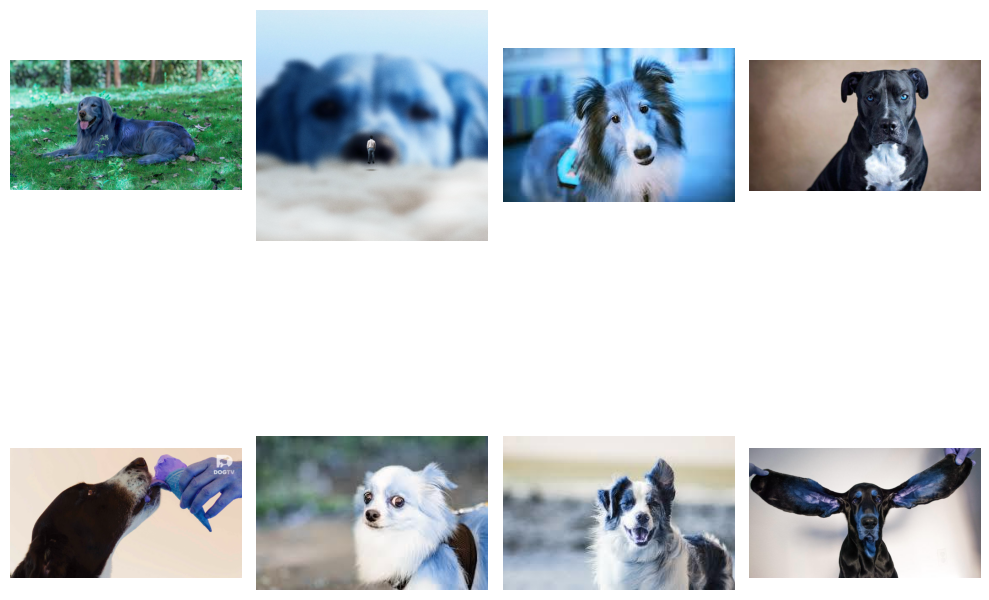

In [28]:
import matplotlib.pyplot as plt
import cv2
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images1):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../input/cats-and-dogs-image-classification/train/dogs", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

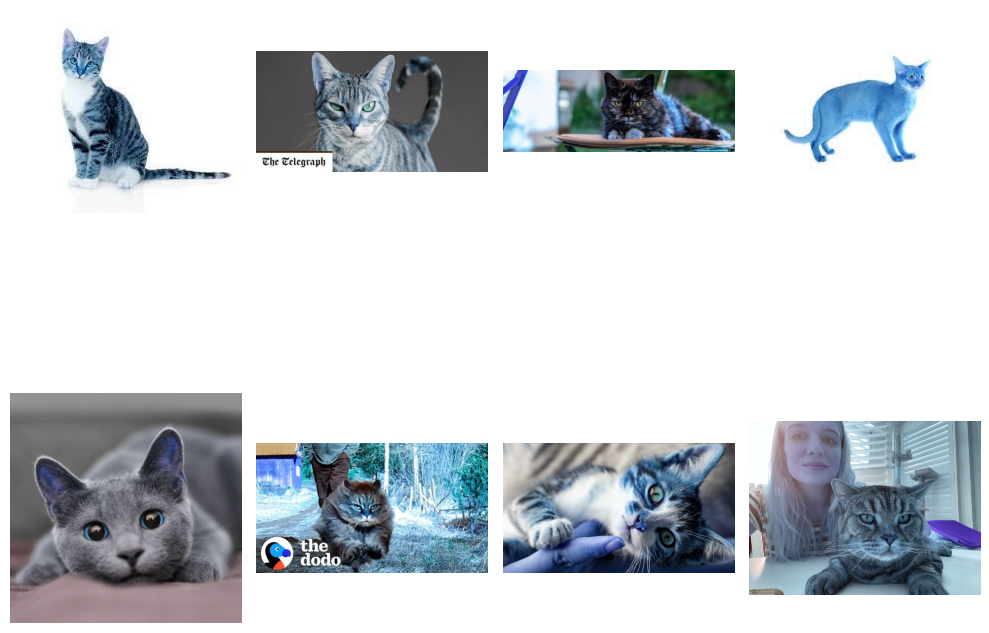

In [29]:
fig = plt.figure(figsize=(10,10))
for i, im in enumerate(rand_images2):
    plt.subplot(2,4 , i+1)
    im = cv2.imread(os.path.join("../input/cats-and-dogs-image-classification/train/cats", im))
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x,y,test_size=0.2,random_state=5)
print("Splitting data for train and val completed.")

Splitting data for train and val completed.


In [44]:
ytrain.shape

(445, 2)

In [32]:
#Creating our ViT model
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [31]:
!pip install vit_keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=b0416e65d475de25eec370f25bd100d7194e2c6e56ecfc28a3d050788406645f
  Stored in directory: /root/.cache/pip/wheels/3d/7c/f1/f87f51d07a2513aa0fb128d5eb504da1fcef9c87475d9eef64
Successfully built validators


In [33]:
from vit_keras import vit
import tensorflow as tf
import tensorflow_addons as tfa
import math

**BASE VIT 16 MODEL **

In [61]:
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


In [62]:
model1 = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model1.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 20)                15380     
                                                                 
 batch_normalization_3 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 2)          

In [65]:
model1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model1.hdf5',
                                                  monitor = 'accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [38]:

callbacks = [early_stopping, checkpointer, lr_scheduler]

In [48]:
num_train_samples = len(xtrain)
num_val_samples = len(xval)
train_batch_size = 16
val_batch_size = 16
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [50]:
train_steps

28.0

In [66]:

hist = model1.fit(xtrain, ytrain, epochs=20, callbacks=callbacks, validation_data=(xval,yval))


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.5236
Epoch 1: val_accuracy did not improve from 0.66964
14/14 [==============================] - 58s 1s/step - loss: 0.9599 - accuracy: 0.5236 - val_loss: 1.0939 - val_accuracy: 0.3750 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.8329 - accuracy: 0.5618
Epoch 2: val_accuracy did not improve from 0.66964
14/14 [==============================] - 11s 811ms/step - loss: 0.8329 - accuracy: 0.5618 - val_loss: 0.9263 - val_accuracy: 0.3750 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.5888
Epoch 3: val_accuracy did not improve from 0.66964
14/14 [==============================] - 12s 831ms/step - loss: 0.7162 - accuracy: 0.5

In [24]:
num_train_samples = len(train_ds)
num_val_samples = len(vald_ds)

In [25]:
train_steps = np.ceil(num_train_samples / batch_size)
val_steps = np.ceil(num_val_samples / batch_size)